# Predicting Match Outcomes in League of Legends

## Imports

In [217]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns

In [218]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [219]:
with open('config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

## Load the dataset
'data' is expected to be a CSV file with game data named 'match_data_v5.csv' and "'match_data_chall_v1.csv'".

In [220]:
df_gm = pd.read_csv(cfg["classification"]["lol_grandmaster"])
df_d = pd.read_csv(cfg["classification"]["lol_diamond"])

### Display the features of the dataset to understand its structure


In [221]:
target = 'blueWin'
features = list(df_d.columns)

features.remove('blueWin')
features

['matchId',
 'blueTeamControlWardsPlaced',
 'blueTeamWardsPlaced',
 'blueTeamTotalKills',
 'blueTeamDragonKills',
 'blueTeamHeraldKills',
 'blueTeamTowersDestroyed',
 'blueTeamInhibitorsDestroyed',
 'blueTeamTurretPlatesDestroyed',
 'blueTeamFirstBlood',
 'blueTeamMinionsKilled',
 'blueTeamJungleMinions',
 'blueTeamTotalGold',
 'blueTeamXp',
 'blueTeamTotalDamageToChamps',
 'redTeamControlWardsPlaced',
 'redTeamWardsPlaced',
 'redTeamTotalKills',
 'redTeamDragonKills',
 'redTeamHeraldKills',
 'redTeamTowersDestroyed',
 'redTeamInhibitorsDestroyed',
 'redTeamTurretPlatesDestroyed',
 'redTeamMinionsKilled',
 'redTeamJungleMinions',
 'redTeamTotalGold',
 'redTeamXp',
 'redTeamTotalDamageToChamps',
 'Unnamed: 29']

## Display the first few rows for deeper understanding

In [222]:
df_d.head()

,matchId,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,...,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin,Unnamed: 29
0,EUW1_6882489515',2,23,4,2,0,0,0,7,0,...,2,0,1,400,94,29637,32613,27239,1,0
1,EUW1_6882416210',2,46,12,1,0,1,0,10,0,...,1,0,4,373,76,28970,30320,36585,0,0
2,EUW1_6881092720',2,19,13,0,0,0,0,11,0,...,2,0,3,340,84,30510,29464,42984,0,0
3,EUW1_6879405717',3,28,8,0,1,1,0,9,1,...,0,0,5,378,87,25157,31069,28229,0,0
4,EUW1_6879389461',3,30,11,1,1,1,0,7,0,...,1,0,5,382,96,26052,29475,19245,1,0


## Preprocess the data
replace red/blue team resources with resourse diff

In [223]:
def transformer(df: pd.DataFrame) -> pd.DataFrame:
    df_trans = pd.DataFrame()
    for i in df.columns:
        if i.startswith("blue"):
            characteristic = i[4:]  
            red_column = f"red{characteristic}"  
            if red_column in df.columns:  
                df_trans[f"{characteristic}Diff"] = df[i] - df[red_column]
    df_trans['blueWin'] = df['blueWin']
    df_trans['blueTeamFirstBlood'] = df['blueTeamFirstBlood']
    return df_trans
df_d = transformer(df_d)
df_gm = transformer(df_gm)
features = list(df_d.columns)
features.remove('blueWin')
df_d.head()


,TeamControlWardsPlacedDiff,TeamWardsPlacedDiff,TeamTotalKillsDiff,TeamDragonKillsDiff,TeamHeraldKillsDiff,TeamTowersDestroyedDiff,TeamInhibitorsDestroyedDiff,TeamTurretPlatesDestroyedDiff,TeamMinionsKilledDiff,TeamJungleMinionsDiff,TeamTotalGoldDiff,TeamXpDiff,TeamTotalDamageToChampsDiff,blueWin,blueTeamFirstBlood
0,-4,-11,-12,2,0,-2,0,6,-12,12,-5714,-2815,-5397,1,0
1,-4,20,-5,1,0,0,0,6,-25,22,-1118,210,-768,0,0
2,-1,-222,-5,-1,0,-2,0,8,-9,12,-2384,37,-4945,0,0
3,3,5,-2,-1,1,1,0,4,-23,-3,2176,-603,3109,0,1
4,-4,4,4,0,1,0,0,2,-12,4,1720,1591,7431,1,0


## Plot heatmap
Let's plot the heatmap in order to spot correlations.

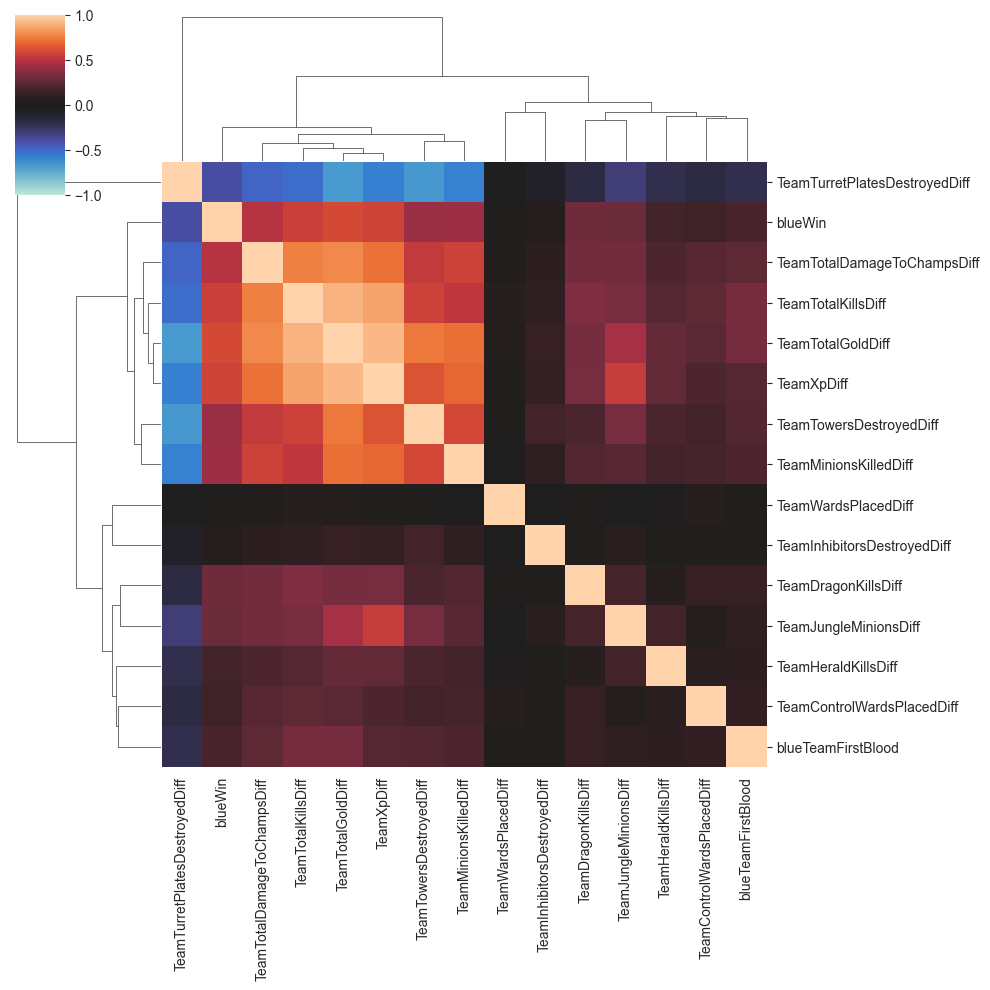

In [224]:

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_gm, annot=None)

## Plot the parameters distribution
Let's plot parameters distribution in order to check, should we normalize data or not (spoiler: it's not necessary for trees, but still good thing to do)

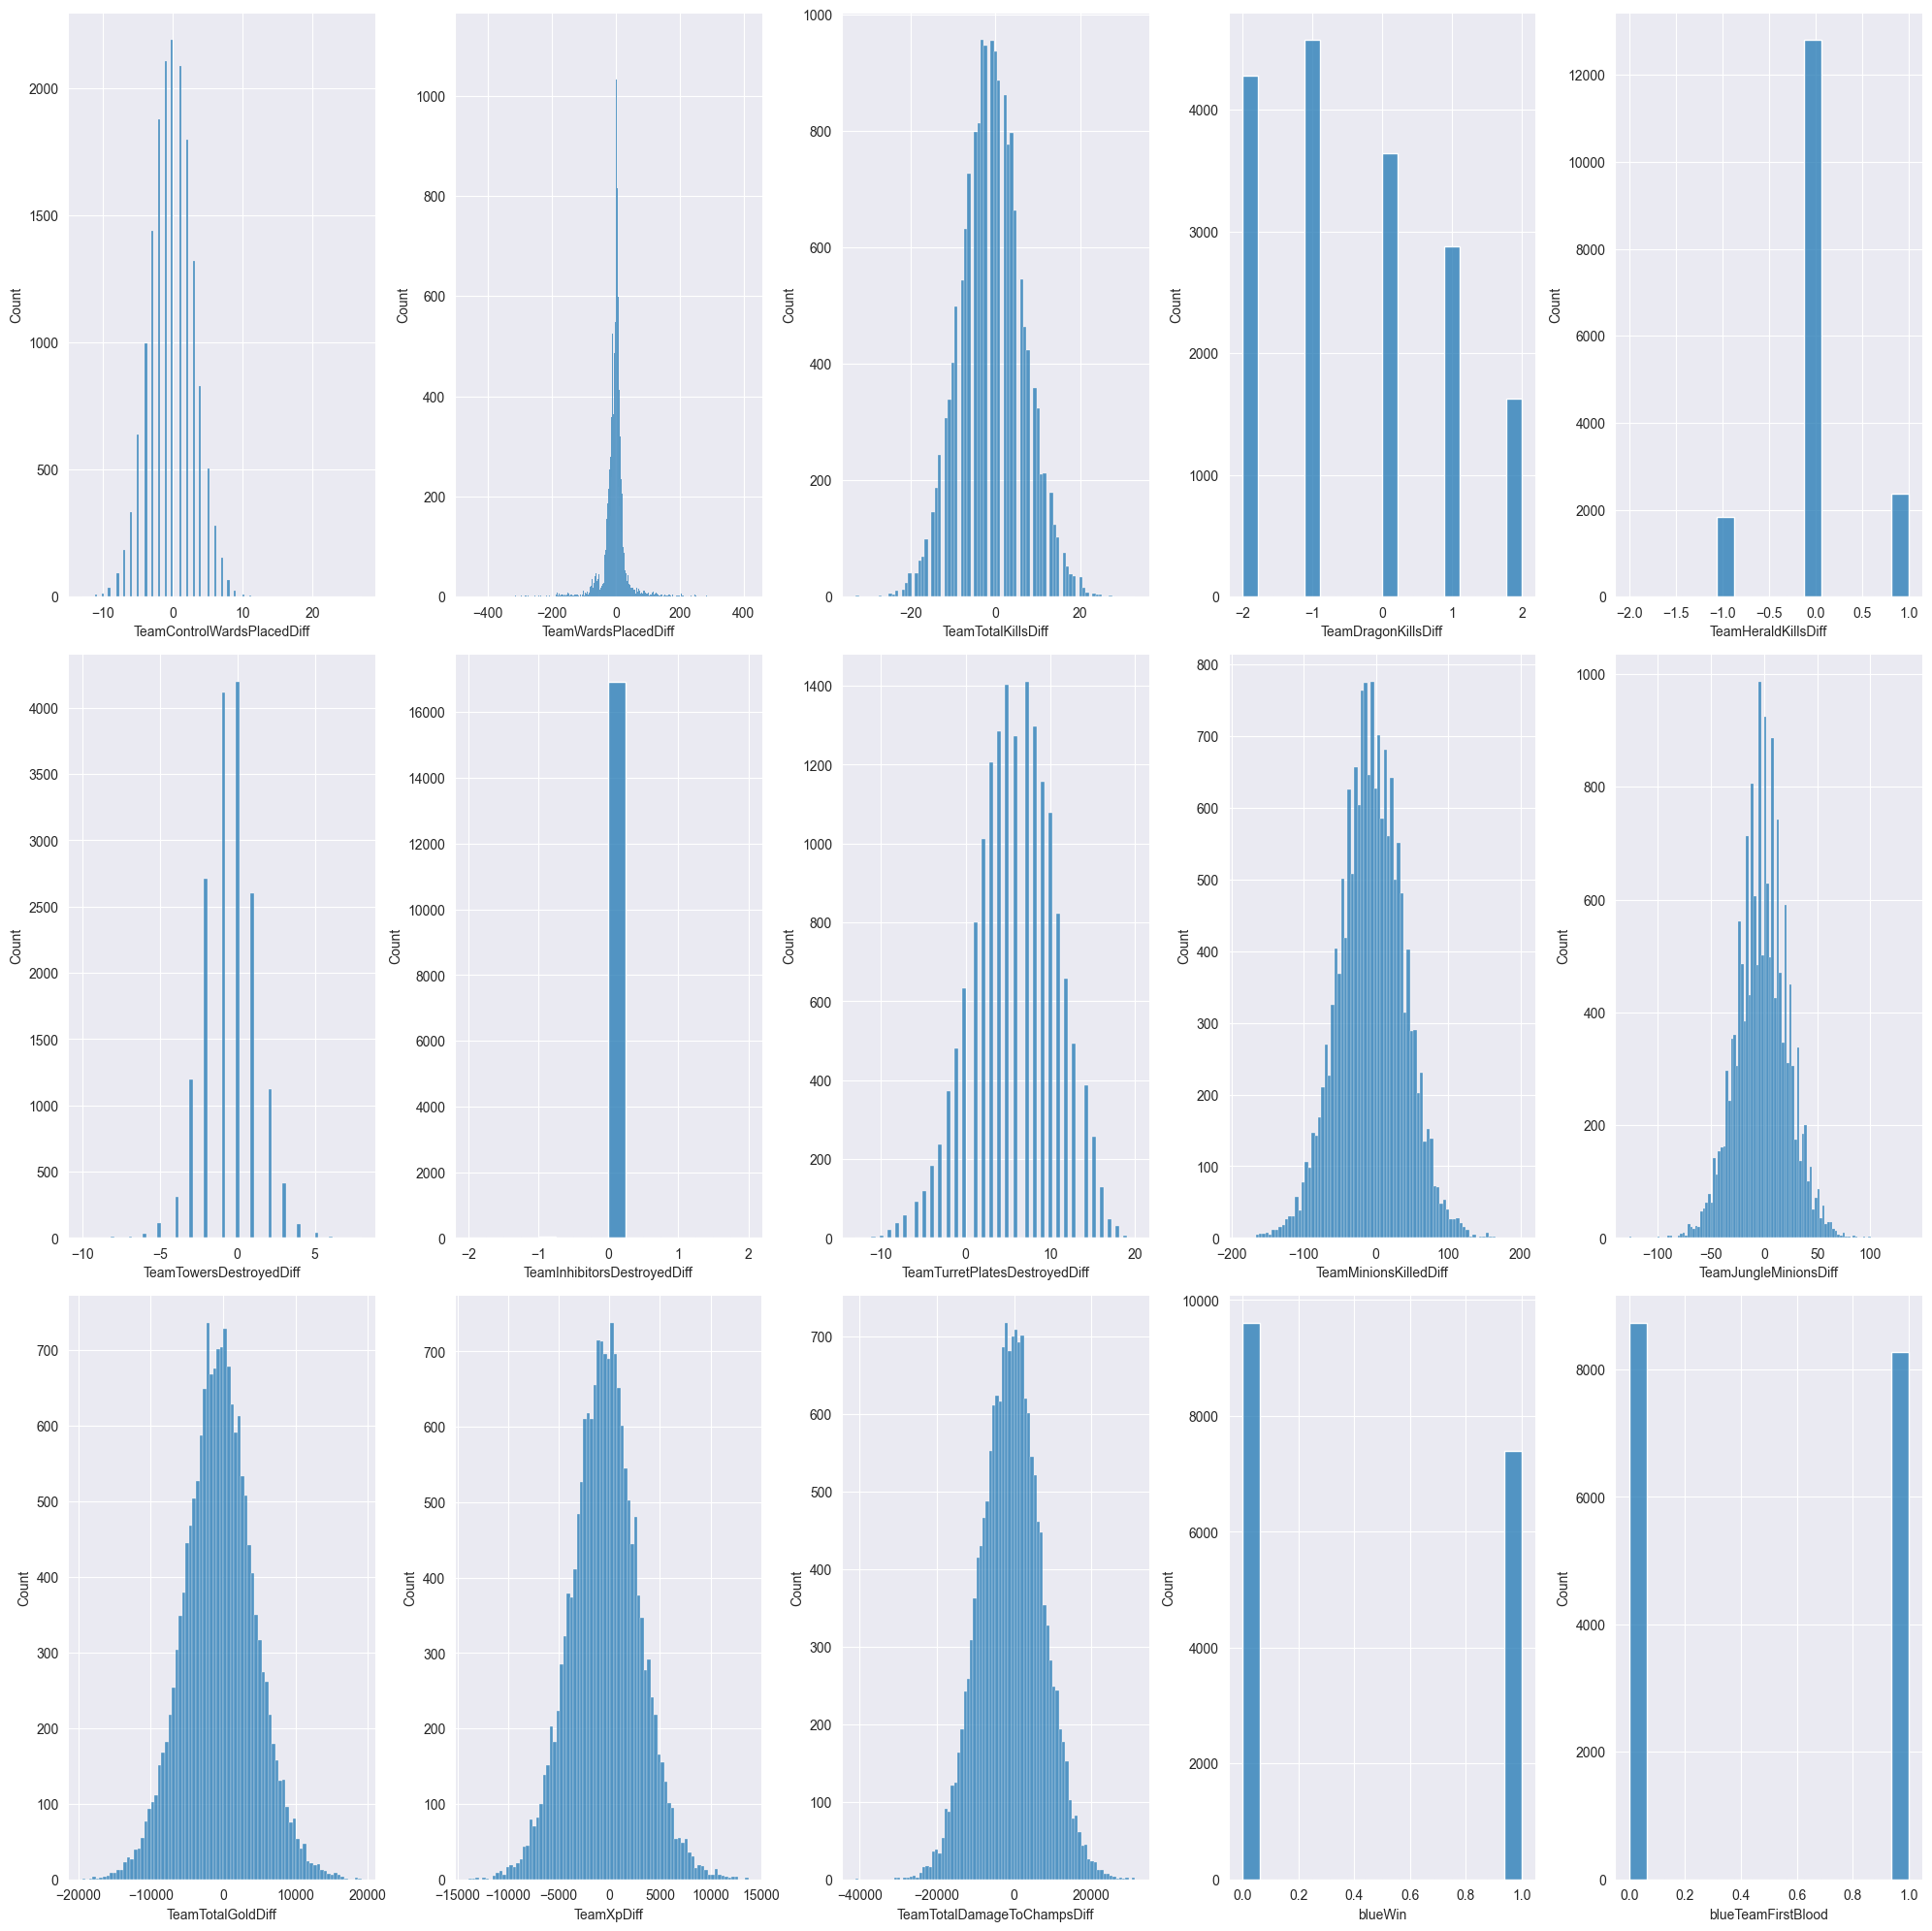

In [225]:
fig, axes = plt.subplots(3, 5, figsize=(20, 20))
axes_flattened = axes.reshape(-1)
for i in range(len(df_gm.columns)):
    ax = axes_flattened[i]
    sns.histplot(
        x=df_gm.iloc[:, i],
        data=df_gm.dropna(),
        ax=ax,
    )
fig.tight_layout(pad=1.0)

In [226]:
X_diamond = df_d[features]
y_diamond = df_d[[target]]
X_grandmaster = df_gm[features]
y_grandmaster = df_gm[[target]]

Now let's make train/test split

In [227]:
X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(X_grandmaster, y_grandmaster, test_size=0.20, random_state=1)
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_diamond, y_diamond, test_size=0.20, random_state=1)

And normalize the data.

In [228]:
clf = LogisticRegression()
ss = StandardScaler()
X_d_train = ss.fit_transform(X_d_train)
X_d_test = ss.transform(X_d_test)
X_gm_train = ss.fit_transform(X_gm_train)
X_gm_test = ss.transform(X_gm_test)

some minor stuff

In [230]:
def PrintTest(name, Classifier, X_train, y_train, X_test, y_test)->None:
    Classifier.fit(X_train, y_train)
    print(f" --- Classifier: {name}")
    print('Training set score: {:.4f}'.format(Classifier.score(X_train, y_train)))
    print('Test set score: {:.4f}'.format(Classifier.score(X_test, y_test)))

## Tests for diamond elo dataset

In [231]:
PrintTest("Tree", DecisionTreeClassifier(max_depth=5, min_samples_leaf=20), X_d_train, y_d_train, X_d_test, y_d_test)
PrintTest("Tree (entropy)", DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0), X_d_train, y_d_train, X_d_test, y_d_test)
PrintTest("Tree (gini)", DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0), X_d_train, y_d_train, X_d_test, y_d_test)
PrintTest("Random Forest", RandomForestClassifier(n_estimators=1000), X_d_train, y_d_train, X_d_test, y_d_test)
PrintTest("LogReg", LogisticRegression(), X_d_train, y_d_train, X_d_test, y_d_test)
PrintTest("GaussianNB", GaussianNB(), X_d_train, y_d_train, X_d_test, y_d_test)

Classifier: Tree
Training set score: 0.7598
Test set score: 0.7612
Classifier: Tree (entropy)
Training set score: 0.7603
Test set score: 0.7612
Classifier: Tree (gini)
Training set score: 0.7602
Test set score: 0.7608


C:\Program Files\Python39\AlgoSem2\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classifier: Random Forest
Training set score: 1.0000
Test set score: 0.7610
Classifier: LogReg
Training set score: 0.7601
Test set score: 0.7628
Classifier: GaussianNB
Training set score: 0.7522
Test set score: 0.7552


C:\Program Files\Python39\AlgoSem2\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files\Python39\AlgoSem2\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Tests for Grandmaster Elo dataset

In [232]:
PrintTest("Tree", DecisionTreeClassifier(max_depth=5, min_samples_leaf=20), X_gm_train, y_gm_train, X_gm_test, y_gm_test)
PrintTest("Tree (entropy)", DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1), X_gm_train, y_gm_train, X_gm_test, y_gm_test)
PrintTest("Tree (gini)", DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=1), X_gm_train, y_gm_train, X_gm_test, y_gm_test)
PrintTest("Random Forest", RandomForestClassifier(n_estimators=1000), X_gm_train, y_gm_train, X_gm_test, y_gm_test)
PrintTest("LogReg", LogisticRegression(), X_gm_train, y_gm_train, X_gm_test, y_gm_test)
PrintTest("GaussianNB", GaussianNB(), X_gm_train, y_gm_train, X_gm_test, y_gm_test)

Classifier: Tree
Training set score: 0.7837
Test set score: 0.7879
Classifier: Tree (entropy)
Training set score: 0.7842
Test set score: 0.7882
Classifier: Tree (gini)
Training set score: 0.7841
Test set score: 0.7859


C:\Program Files\Python39\AlgoSem2\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classifier: Random Forest
Training set score: 1.0000
Test set score: 0.7909
Classifier: LogReg
Training set score: 0.7869
Test set score: 0.7965
Classifier: GaussianNB
Training set score: 0.7775
Test set score: 0.7815


C:\Program Files\Python39\AlgoSem2\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files\Python39\AlgoSem2\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
